# 1861 Hagelloch Measles

Data references:

* Pfeilsticker, A. 1863. Beiträge zur Pathologie der Masern mit besonderer Berücksichtigung der statistischen Verhältnisse, M.D. Thesis, Eberhard-Karls-Universität Tübingen. Available as http://www.archive.org/details/beitrgezurpatho00pfeigoog.
* Oesterle, H. 1992. Statistische Reanalyse einer Masernepidemie 1861 in Hagelloch, M.D. Thesis, Eberhard-Karls-Universitäat Tübingen.
* Höhle M. 2007. surveillance: An R package for the monitoring of infectious diseases. Computational Statistics, 22:571-582.

In [1]:
using CSV, DelimitedFiles, Distances, Random, Pathogen, Plots, Plots.PlotMeasures, DataFrames;
Random.seed!(4321);

In [2]:
# POPULATION INFOFORMATION
# Use CSV.jl for DataFrames I/O
risks = CSV.read("data/measles_hagelloch_1861_risk_factors.csv")

,age,gender,family_ID,class,x,y
,Int64,String,Int64,Int64,Float64,Float64
1,7,f,41,1,142.5,100.0
2,6,f,41,1,142.5,100.0
3,4,f,41,0,142.5,100.0
4,13,m,61,2,165.0,102.5
5,8,f,42,1,145.0,120.0
6,12,m,42,2,145.0,120.0
7,6,m,26,0,272.5,147.5
8,10,m,44,1,97.5,155.0
9,13,m,44,2,97.5,155.0


In [3]:
# Will precalculate distances
distance = [euclidean([risks[i, :x]; risks[i, :y]], [risks[j, :x]; risks[j, :y]]) for i = 1:size(risks, 1), j = 1:size(risks, 1)]
temp1 = [prod(risks[[i, j], :class]) for i = 1:size(risks, 1), j = 1:size(risks, 1)]
sameclass = temp1 .∈ Ref([1, 4])
samehousehold = distance .== 0.0
distance[samehousehold] .= Inf
dist = [(distance[i, j], sameclass[i, j], samehousehold[i, j]) for i = 1:size(risks, 1), j = 1:size(risks, 1)]

pop = Population(risks, dist)

Population object (n=188)

In [4]:
# Define risk functions/TN-ILM structure
function _constant(params::Vector{Float64}, pop::Population, i::Int64)
  return params[1]
end

function _one(params::Vector{Float64}, pop::Population, i::Int64)
  return 1.0
end

function _powerlaw_plus(params::Vector{Float64}, pop::Population, i::Int64, k::Int64)
  return params[1] * pop.distances[k, i][1]^(-params[2]) +
         params[3] * pop.distances[k, i][2] +
         params[4] * pop.distances[k, i][3]
end

rf = RiskFunctions{SEIR}(_constant, # sparks function
                         _one, # susceptibility function
                         _powerlaw_plus, # infectivity function
                         _one, # transmissability function
                         _constant, # latency function
                         _constant) # removal function

SEIR model risk functions

In [5]:
obsdata = CSV.read("data/measles_hagelloch_1861_observations.csv")

# Set the removal observation as minimum of (day that rash appears + 4.0) and death, in fatal cases.
removed = [obsdata[i, :death] === NaN ? obsdata[i, :rash] + 4.0 : min(obsdata[i, :rash] + 4.0, obsdata[i, :death]) for i = 1:188]

# Set prodrome within first 7 days of epidemic as initial conditions
infected = obsdata[:, :prodrome]
# starting_states = [i <= 10.0 ? State_I : State_S for i in infected]
# infected[infected .<= 10.0] .= -Inf
obs = EventObservations{SEIR}(infected, removed)

SEIR model observations (n=188)

In [6]:
# Specify some priors for the risk parameters of our various risk functions
rpriors = RiskPriors{SEIR}([Uniform(0.0, 0.1)],
                           UnivariateDistribution[],
                           [Uniform(0.0, 7.0); Uniform(0.0, 7.0); Uniform(0.0, 1.0); Uniform(0.0, 1.0)],
                           UnivariateDistribution[],
                           [Uniform(0.0, 1.0)],
                           [Uniform(0.0, 1.0)])

# Using CDC measles information set some extents for event data augmentation
# Exposure up to 2 weeks before infectiousness, with a minimum of 5 days between exposure and infectiousness
# Infectious up to 3 days before prodrome
# Removal time within 2-4 days after rash
ee = EventExtents{SEIR}((5.0, 14.0), 3.0, 2.0)

SEIR model event extents

In [7]:
# Initialize MCMC
mcmc = MCMC(obs, ee, pop, rf, rpriors)
start!(mcmc, attempts=100000) # 1 chain, with 100k initialization attempts

# Run MCMC
iterate!(mcmc, 200000, 1.0, condition_on_network=true, event_batches=10)

Initialization progress100%|████████████████████████████| Time: 0:14:35:37
MCMC progress100%|██████████████████████████████████████| Time: 3:52:59m26m


SEIR model MCMC with 1 chains

In [7]:
using JLD2;
#@save "mcmc.jld2" mcmc;
@load "mcmc.jld2" mcmc;

In [9]:
gr(dpi=200); # GR backend with DPI=200

In [10]:
# MCMC and posterior plots
p1 = plot(1:20:200001, mcmc.markov_chains[1].risk_parameters, yscale=:log10, title="TN-ILM parameters")
png(p1, joinpath(@__DIR__, "trace.png"))

![TN-ILM traceplot](trace.png)

In [11]:
p2 = plot(mcmc.markov_chains[1].events[100000], State_S,
          linealpha=0.01, title="S", xguidefontsize=8, yguidefontsize=8,
          xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=100050:50:200000
  plot!(p2, mcmc.markov_chains[1].events[i], State_S, linealpha=0.02)
end

p3 = plot(mcmc.markov_chains[1].events[100000], State_E,
          linealpha=0.01, title="E", xguidefontsize=8, yguidefontsize=8,
          xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=100050:50:200000
  plot!(p3, mcmc.markov_chains[1].events[i], State_E, linealpha=0.02)
end

p4 = plot(mcmc.markov_chains[1].events[100000], State_I,
          linealpha=0.01, title="I", xguidefontsize=8, yguidefontsize=8, xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=100050:50:200000
  plot!(p4, mcmc.markov_chains[1].events[i], State_I, linealpha=0.02)
end
plot!(p4, obs, State_I, linecolor=:black, linewidth=1.5) # Show infection observations (day of prodrome)

p5 = plot(mcmc.markov_chains[1].events[100000], State_R,
          linealpha=0.01, title="R", xguidefontsize=8, yguidefontsize=8, xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=100050:50:200000
  plot!(p5, mcmc.markov_chains[1].events[i], State_R, linealpha=0.02)
end
plot!(p5, obs, State_R, linecolor=:black, linewidth=1.5) # Show removal observations (day of appearance of rash + 4)

l = @layout [a b c d]
combinedplots1 = plot(p2, p3, p4, p5, layout=l, link=:y, size=(800,200))
png(combinedplots1, joinpath(@__DIR__, "posterior_epi_curves.png"))

![Epidemic Curve Posterior](posterior_epi_curves.png)

In [41]:
tnp = TransmissionNetworkPosterior(mcmc, burnin=100000, thin=50)

TransmissionNetworkDistribution Σexternal = 7.7036481759120425 Σinternal = 180.29635182408796

In [13]:
tnoesterle = TransmissionNetwork(BitArray(readdlm("data/oesterle_tn_external.csv")[:]), BitArray(readdlm("data/oesterle_tn_internal.csv")))

TransmissionNetwork Σexternal = 4 Σinternal = 184

In [14]:
# As there are several individuals at single locations, jitter locations to better illustrate the 
# transmission network distribution
xyjitter = select(risks, :x, :y)
xyjitter[:, :x] = xyjitter[:, :x] + rand(Normal(0, 3), 188)
xyjitter[:, :y] = xyjitter[:, :y] + rand(Normal(0, 3), 188)
plotpop = Population(xyjitter)

Population object (n=188)

In [15]:
p6 = plot(tnp, plotpop, title="Transmission Network Posterior Distribution", titlefontsize=11, framestyle=:box, markeralpha=0.5, size=(400, 400))

png(p6, joinpath(@__DIR__, "posterior_tn.png"))

In [16]:
p7 = plot(tnoesterle, plotpop, title="Oesterle (1992) Transmission Network", titlefontsize=11, framestyle=:box, markeralpha=0.5, size=(400, 400))

png(p7, joinpath(@__DIR__, "Oesterle_tn.png"))

In [17]:
l = @layout [a b]
combinedplots2 = plot(p6, p7, layout=l, size=(800, 400))
png(combinedplots2, joinpath(@__DIR__, "tn_side_by_side.png"))

![Transmission Posterior](tn_side_by_side.png)

In [18]:
l = @layout [grid(1,2){0.6h}
             grid(1,4)]
combinedplots3 = plot(p6, p7, p2, p3, p4, p5, layout=l, size=(1000, 600))
png(combinedplots3, joinpath(@__DIR__, "overview.png"))

![Inference overview](overview.png)

In [20]:
# Get a summary of TN-ILM parameters
summary(mcmc, burnin=100000, thin=50)

,parameter,mean,var,CI
,String,Float64,Float64,Tuple…
1,ϵ₁,0.00126149,4.10697e-7,"(0.000331872, 0.00284014)"
2,κ₁,4.13757,3.37574,"(0.600692, 6.87183)"
3,κ₂,1.96294,0.0331777,"(1.4777, 2.22672)"
4,κ₃,0.0200552,1.14699e-5,"(0.0139816, 0.0271123)"
5,κ₄,0.195211,0.00117201,"(0.13244, 0.269877)"
6,Ωl₁,0.125853,8.73529e-5,"(0.108376, 0.145191)"
7,Ωr₁,0.120987,8.10217e-5,"(0.103854, 0.139071)"


In [19]:
p8 = plot(tnp, size=(500,400), title="Transmission network posterior\ndegree distribution", titlefontsize=11)
png(p8, joinpath(@__DIR__, "outdegree.png"))

![Posterior transmission network out degree](outdegree.png)

In [21]:
Pathogen._outdegree(tnoesterle)[45]

30

In [22]:
Pathogen._outdegree(tnp)[45]

11.114942528735638

In [23]:
sum(mode(tnp).internal .* tnoesterle.internal) + sum(mode(tnp).external .* tnoesterle.external)

103

In [24]:
sum(tnp.external)

7.7036481759120425

In [23]:
pm_events = mean(mcmc.markov_chains[1].events[100000:50:200000])

SEIR model event times (n=188)

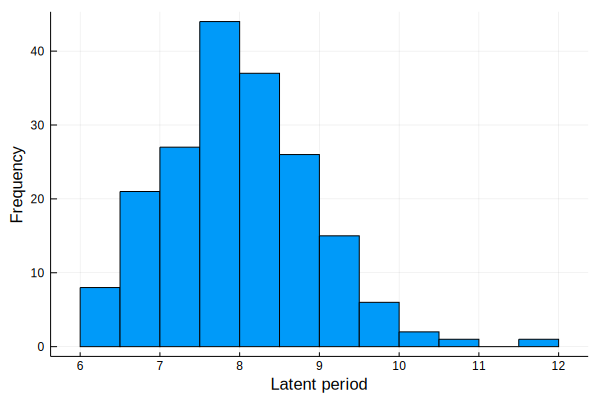

In [35]:
histogram(pm_events.infection .- pm_events.exposure, legend=:none, ylabel="Frequency", xlabel="Latent period")

In [29]:
mean(pm_events.infection .- pm_events.exposure)

7.980969853022001

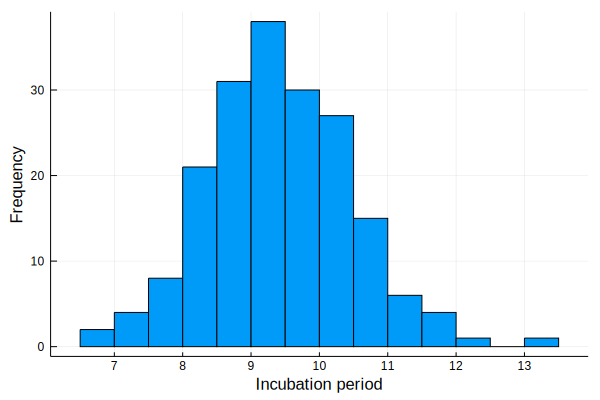

In [34]:
histogram(obs.infection .- pm_events.exposure, legend=:none, ylabel="Frequency", xlabel="Incubation period")

In [30]:
mean(obs.infection .- pm_events.exposure)

9.418605077939166

In [39]:
argmax(obs.infection)

141

In [43]:
sort(obs.infection)

188-element Array{Float64,1}:
  0.0
  2.0
  8.0
  8.0
  9.0
 12.0
 12.0
 13.0
 14.0
 16.0
 16.0
 18.0
 19.0
  ⋮
 42.0
 42.0
 43.0
 43.0
 43.0
 44.0
 44.0
 44.0
 45.0
 46.0
 46.0
 86.0

In [42]:
tnp.external[141]

1.0